In [1]:
import pandas
import numpy
import random
import json
import itertools
class ParetoSearcher(object):
    
    def __init__(self, not_pareto_config):
        self.not_pareto_config = not_pareto_config
        self.not_pareto_rule = []
        self.rest_df = None

    def divide(self, df):
        self.rest_df = df[self.not_pareto_config.keys()].copy()
        for rule in self.not_pareto_rule:
            bool_series = self._bool_series(rule)
            if bool_series.sum() == 0:
                continue
            self.rest_df = self.rest_df[~bool_series]
        return df.loc[self.rest_df.index]
        
    def search(self, df):
        self.rest_df = df[self.not_pareto_config.keys()].copy()
        #self._append_id()
        for i in self.rest_df.index:
            #print(i)
            self._iteration(i)
        return df.loc[self.rest_df.index]

    def compress_rule(self):
        def _compare(v1, v2, sign):
            if sign == ">=":
                return v1 >= v2
            elif sign == ">":
                return v1 > v2
            elif sign == "<=":
                return v1 <= v2
            elif sign == "<":
                return v1 < v2
            elif sign == "==":
                return v1 == v2
            elif sign == "!=":
                return v1 != v2
            else:
                raise Exception("Invalid sign: {}".format(sign))

        def _is_small_rule(rule_1, rule_2):
            # rule_1 < rule_2を返す
            return all([_compare(rule_1[col], rule_2[col], sign) for col, sign in self.not_pareto_config.items()])

        not_pareto_rule = self.not_pareto_rule.copy()
        for rule_1, rule_2 in list(itertools.permutations(self.not_pareto_rule, 2)):
            if rule_1 not in not_pareto_rule or rule_2 not in not_pareto_rule:
                continue
            if _is_small_rule(rule_1, rule_2):
                # rule_1 < rule_2なのでrule_1はいらない
                not_pareto_rule.remove(rule_1)
        self.not_pareto_rule = not_pareto_rule
    
    def _iteration(self, i):
        if i not in self.rest_df.index:
            #print("not index {}".format(i))
            return
        values = self.rest_df.loc[i].values
        rule = {col: v for v, col in zip(values, self.not_pareto_config.keys())}
        self.not_pareto_rule.append(rule)
        bool_series = self._bool_series(rule)
        if bool_series.sum() == 0:
            return
        self.rest_df = self.rest_df[~bool_series]
        
    def _bool_series(self, rule):
        # not paretoなseriesを取得
        bool_series = pandas.Series([True]*len(self.rest_df), index=self.rest_df.index)
        for col, sign in self.not_pareto_config.items():
            s = self._filter(self.rest_df[col], sign, rule[col])
            bool_series = bool_series & s
        return bool_series
        
    
    def _append_id(self):
        assert "Id" not in self.rest_df.columns, "Id must not be in df.columns"
        self.rest_df["Id"] = self.rest_df.index
        
    def _filter(self, series, sign, value):
        if sign == ">=":
            return series >= value
        elif sign == ">":
            return series > value
        elif sign == "<=":
            return series <= value
        elif sign == "<":
            return series < value
        elif sign == "==":
            return series == value
        elif sign == "!=":
            return series != value
        else:
            raise Exception("Invalid sign: {}".format(sign))
            
    def save_rule(self, filepath):
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(self.not_pareto_rule, f, cls=MyEncoder, indent=4, ensure_ascii=False)
            
    def load_rule(self, filepath):
        with open(filepath, "r", encoding="utf-8") as f:
            d = json.load(f)
        self.not_pareto_rule = d

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.integer):
            return int(obj)
        elif isinstance(obj, numpy.floating):
            return float(obj)
        elif isinstance(obj, numpy.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

/home/ubuntu/.pyenv/versions/3.7.3/envs/dev/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/ubuntu/.pyenv/versions/3.7.3/envs/dev/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# not_paretoの条件
not_pareto_config = {
    "x1": ">",
    "x2": "<",
    #"x3": "<",
    "x4": "=="#,
    #"x5": "=="
}

self = ParetoSearcher(not_pareto_config)
n = 1000
#x1 = numpy.random.rand(n)
#x2 = numpy.sqrt(1 - x1 ** 2)
x1 = numpy.random.randint(0, 10, n)
x2 = numpy.random.randint(0, 10, n)
x3 = numpy.random.rand(n)
x4 = random.choices(["a", "b", "c"], k=n)
#x5 = random.choices(["d", "e", "f"], k=n)

df = pandas.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4})#sort_values("x1").reset_index(drop=True)
df["Id"] = df.index
pareto_df= self.search(df)
print(len(self.not_pareto_rule))
self.compress_rule()
print(len(self.not_pareto_rule))


191
171


In [3]:
self.save_rule("not_pareto_rule.json")

In [4]:
pareto_df["pareto"] = 1
feature_data = df.merge(pareto_df, how="left")
feature_data["pareto"] = feature_data["pareto"].fillna(0)

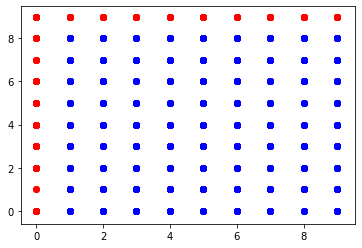

In [6]:
pareto = feature_data.query("pareto == 1").reset_index(drop=True)
no_pareto = feature_data.query("pareto == 0").reset_index(drop=True)
import matplotlib.pyplot as plt
plt.scatter(pareto["x1"], pareto["x2"], c="r")
plt.scatter(no_pareto["x1"], no_pareto["x2"], c="b")


In [7]:
self.load_rule("not_pareto_rule.json")

In [8]:
pareto_df = self.divide(df)

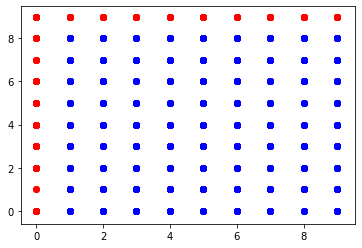

In [9]:
pareto_df["pareto"] = 1
feature_data = df.merge(pareto_df, how="left")
feature_data["pareto"] = feature_data["pareto"].fillna(0)

pareto = feature_data.query("pareto == 1").reset_index(drop=True)
no_pareto = feature_data.query("pareto == 0").reset_index(drop=True)
import matplotlib.pyplot as plt
plt.scatter(pareto["x1"], pareto["x2"], c="r")
plt.scatter(no_pareto["x1"], no_pareto["x2"], c="b")
